In [2]:
import funct
import importlib
import numpy as np
import pandas as pd
import os
import IPython
import netCDF4 as nc
import  xarray as xr
from datetime import datetime, timedelta

Read historical CCS data

Incomplete data of June, 2021\
Data up to 2024/3/8, need to dynamically download data after this date

In [3]:
freq = 3
rela_path_base = "Data\Persian_CCS_201901_202403\CCS_esmJSON_2024-03-08075032am_"


# Get the current working directory
current_dir = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir(parent_dir)
# Now, your current working directory is the parent folder.

df_list = []
first_iter = True
for month in funct.iterate_months(2019, 1, 2024, 3):
    rela_path = rela_path_base + month + ".nc"
    df = funct.create_time_series_dataframe(freq, rela_path)
    if first_iter:
        df = df.replace(-99,np.nan)
        cols_after_drop = df.dropna(axis=1, how='any').columns
        first_iter = False
    df_dropped = df[[col for col in cols_after_drop]]
    df_list.append(df_dropped)
df_ccs = pd.concat(df_list)
# orginal shape of the Esmeraldas basin is of size 53*52
# New flat array of 1098 pixels, showing only the net pixels of this basin area 

# Read and organize data from Esmeraldas station
## First, check the ftp and download the most recent observation from it if it's not in the local folder yet

In [4]:
# update the dataset dynamically from the FTP
from ftplib import FTP

local_folder = "path/to/local/folder"
local_base_folder = "Data\Esm_Station"

# FTP server details
ftp_server = "186.42.174.238"
username = "sistec"
password = "ftpst2012"

# Connect to the FTP server
ftp = FTP(ftp_server)
ftp.login(username, password)

# Change to the desired directory (optional)
ftp.cwd("TEST_ESTACIONES_AUTOMATICAS/H5033/D1/F10")

# List all the files and folders in the current directory
files_and_folders = ftp.nlst()

# Filter out the folders starting with "yd"
yd_folders = [folder for folder in files_and_folders if folder.startswith("yd")]
# Find the folder with the largest number after "yd"
latest_folder = max(yd_folders, key=lambda x: int(x[2:]))
# Change to the latest folder
ftp.cwd(latest_folder)
files_and_folders = ftp.nlst()

# Filter out the folders starting with "md"
md_folders = [folder for folder in files_and_folders if folder.startswith("md")]
# Find the folder with the largest number after "md"
latest_folder = max(md_folders, key=lambda x: int(x[2:]))
# Change to the latest folder
ftp.cwd(latest_folder)

# List all the CSV files in the latest folder
csv_files = [file for file in ftp.nlst()]

for csv_file in csv_files:
    # Extract the date from the CSV file name
    file_date = datetime.strptime(csv_file[:8], "%Y%m%d").date()

    # Set the specific time to be 23:55 of the file date
    specific_datetime = datetime.combine(file_date, datetime.strptime("23:55", "%H:%M").time())

    # Add one day to the specific time
    specific_datetime += timedelta(days=1)

    # Get the last modified time of the CSV file
    last_modified_time = ftp.voidcmd(f"MDTM {csv_file}")[4:].strip()
    last_modified_datetime = datetime.strptime(last_modified_time, "%Y%m%d%H%M%S")
    print(last_modified_datetime)

    if last_modified_datetime > specific_datetime:
        # Extract the year and month from the CSV file name
        year_folder = f"yd{file_date.year}"
        month_folder = f"md{file_date.strftime('%Y%m')}"

        # Create the year and month folders if they don't exist
        local_year_folder = os.path.join(local_base_folder, year_folder)
        local_month_folder = os.path.join(local_year_folder, month_folder)
        os.makedirs(local_month_folder, exist_ok=True)

        # Check if the CSV file already exists in the local month folder
        local_csv_files = os.listdir(local_month_folder)
        if csv_file not in local_csv_files:
            # Download the CSV file to the local month folder
            local_file_path = os.path.join(local_month_folder, csv_file)
            with open(local_file_path, "wb") as file:
                # Use FTP's RETR command to download the file
                ftp.retrbinary(f"RETR {csv_file}", file.write)
            print(f"Downloaded {csv_file} to {local_month_folder}")
        else:
            print(f"{csv_file} already exists in {local_month_folder}. Skipping download.")
    else:
        print(f"Last modified time of {csv_file}: {last_modified_datetime} is not later than {specific_datetime}. Collection of sensor data unfinished. Skipping download.")
    

ftp.quit()


20240301_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240302_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240303_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240304_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240305_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240306_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240307_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240308_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240309_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240310_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240311_dvd.csv already exists in Data\Esm_Station\yd2024\md202403. Skipping download.
20240312_dvd.csv already exists 

'221 Goodbye.'

In [5]:
funct = importlib.reload(funct)
from datetime import date, timedelta, datetime
from funct import format_number_with_zeros, diff, mmean
import chardet
import re

# Define start and end dates (replace with your desired dates)
start_date = date(2023, 2, 1)  # Adjust year, month, day as needed
end_date = last_modified_datetime.date()  # use the date from the name of the most recent file


# Get the current working directory
current_dir = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir(parent_dir)
# Now, your current working directory is the parent folder.

# Iterate through each day using a for loop and timedelta

df_list_esm = []
df_list_esm_err = []

# iterate to read every .csv file and convert them into transposed dataframe to align with the form of ccs data
for day in range((end_date - start_date).days + 1):
    current_date = start_date + timedelta(days=day)
    # Do something with the current_date here (e.g., print, process data)
    year = current_date.year
    month = format_number_with_zeros(current_date.month,2)
    day = format_number_with_zeros(current_date.day,2)
    csv_path = "Data\Esm_Station\yd" + str(year) + "\md" + str(year) + str(month) + "\\" + str(year) + str(month) + str(day) + "_dvd.csv"
    try:
        with open(csv_path, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
            df = pd.read_csv(csv_path, encoding= encoding, header = None ,skiprows=2)
            df = df[0].apply(lambda x: pd.Series(re.split(';', x)))
            df = df.T
            df.columns = df.iloc[0]
            head = df.iloc[0].values
            df = df.iloc[6:]
            df.drop(df.index[-1],inplace=True)
            df = df.set_index('N Sens', drop = True)
            times = [datetime.strptime(time, '%H.%M') for time in df.index]
            datetimes = [t.replace(year = year, month= current_date.month, day= current_date.day) for t in times]
            df.index = datetimes
            try:
                df.columns = ['hidro_level_m1','precip_acumu_sm','hidro_level_sm']
            except ValueError:
                df.columns = ['hidro_level_m1']
                # record the odd case with only data of a single sensor
                df_list_esm_err.append(df)
                print(current_date, head)
    # exception for missing data
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        encoding = None
        df_temp = df.copy()
        df_temp.index = df_temp.index + pd.Timedelta(days=1)
        df_temp.iloc[:, :] = np.nan
        df = df_temp.copy()
    df_list_esm.append(df)

# Normal run time > 4min

2023-10-01 ['N Sens' '78652']
2023-10-02 ['N Sens' '78652']
2023-10-03 ['N Sens' '78652']
2023-10-04 ['N Sens' '78652']
2023-10-05 ['N Sens' '78652']
2023-10-06 ['N Sens' '78652']
2023-10-12 ['N Sens' '78652']
2023-10-13 ['N Sens' '78652']
2023-10-14 ['N Sens' '78652']
2023-10-15 ['N Sens' '78652']
2023-10-16 ['N Sens' '78652']
2023-10-17 ['N Sens' '78652']
2023-10-18 ['N Sens' '78652']
2023-10-19 ['N Sens' '78652']
2023-10-20 ['N Sens' '78652']
2023-10-21 ['N Sens' '78652']
2023-10-22 ['N Sens' '78652']
2023-10-23 ['N Sens' '78652']
2023-10-24 ['N Sens' '78652']
File not found: Data\Esm_Station\yd2024\md202403\20240328_dvd.csv


In [40]:
# concat all the files
df_esm_all = pd.concat(df_list_esm)
# convert the data to be numeric
df_esm_all = df_esm_all.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == "object" else x)
# convert the values to approriate decimals
df_esm_all['hidro_level_m1'] = df_esm_all['hidro_level_m1']/100
df_esm_all['hidro_level_sm'] = df_esm_all['hidro_level_sm']/100
df_esm_all['precip_acumu_sm'] = df_esm_all['precip_acumu_sm']/1000
# aggregate data with a unit frequency of 3 hours, nan values will be excluded from the calculation
df_esm_all = df_esm_all.replace(-99.99,np.nan)
# the precipitation is a constantly accumulative value, the aggregation method should be the difference of the max and min value
df_esm_3h = df_esm_all.resample('180min').agg({'hidro_level_m1': 'mean', 'precip_acumu_sm': diff, 'hidro_level_sm':'mean'})
df_esm_3h = df_esm_3h.round(2)

In [41]:
import pandas as pd
import plotly
from plotly.graph_objs import Figure, Scatter



# Create a plotly trace
trace = Scatter(
    x=df_esm_3h.index,
    y=df_esm_3h['hidro_level_sm'],  # Assuming the first column is the data to plot
    mode='lines',
)

# Define the layout
layout = {
    "title": "Time Series Plot",
    "xaxis": {"title": "Date", "type": 'date'},
    "yaxis": {"title": "Value"}
}

# Create the plot
fig = Figure(data=[trace], layout=layout)
fig.show()


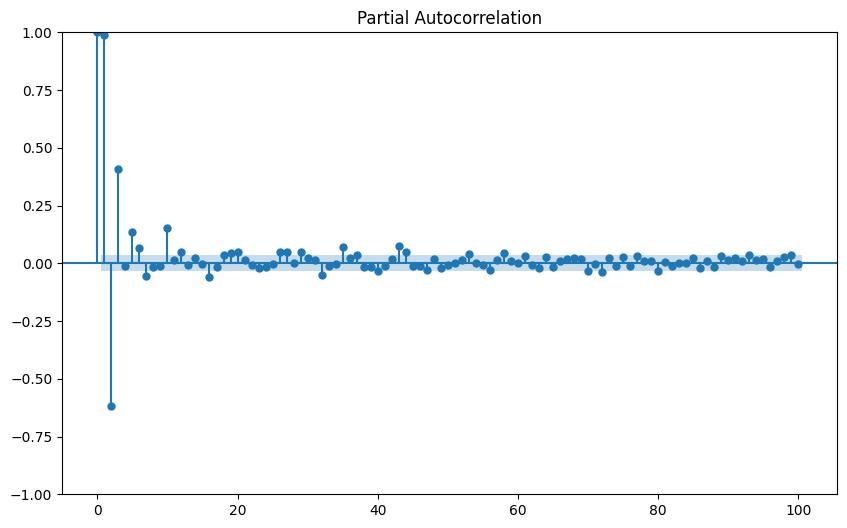

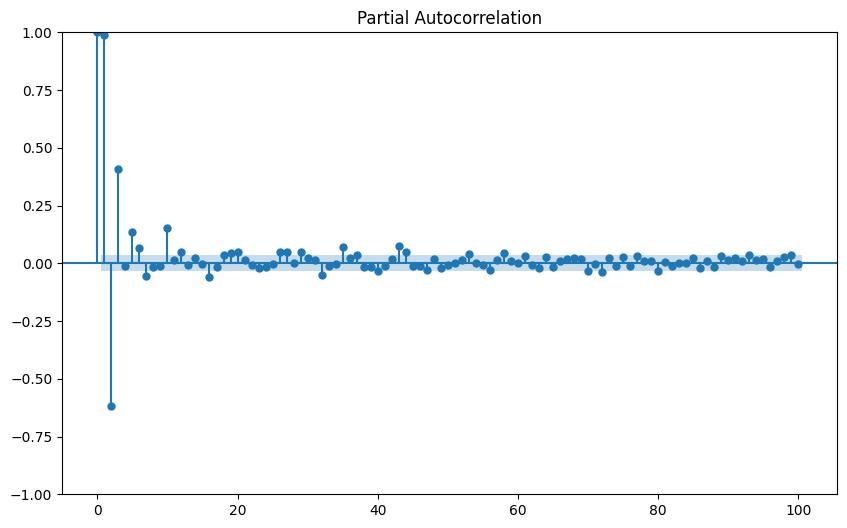

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

discharge_series = df_esm_3h['hidro_level_sm']
discharge_series.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(discharge_series, ax=ax, lags=100)  

In [39]:
df.min()

hidro_level_m1    -49.39
precip_acumu_sm     0.00
hidro_level_sm      1.27
dtype: float64

In [34]:
print(df_esm_3h.loc['2023-09-30 12:00:00': '2023-10-30 12:00:00	'])
a = df.loc['2023-09-15 06:00:00': '2023-09-15 12:00:00	']
a['hidro_level_sm'].min()

                     hidro_level_m1  precip_acumu_sm  hidro_level_sm
2023-09-30 12:00:00            2.05             0.00            4.40
2023-09-30 15:00:00            3.49              NaN            4.47
2023-09-30 18:00:00            1.88              NaN             NaN
2023-09-30 21:00:00            0.36              NaN             NaN
2023-10-01 00:00:00            1.90              NaN             NaN
...                             ...              ...             ...
2023-10-30 00:00:00            2.24             0.00            6.35
2023-10-30 03:00:00            3.48             0.00            6.25
2023-10-30 06:00:00            1.82             0.00            6.15
2023-10-30 09:00:00            0.29             0.00            6.10
2023-10-30 12:00:00            1.67             0.33            6.03

[241 rows x 3 columns]


-99.99

In [36]:
a.replace(-99.99,np.nan).min()

hidro_level_m1        0.79
precip_acumu_sm    1396.92
hidro_level_sm        4.44
dtype: float64

Merge the ccs data and Esmeradals data from CAE together and output to the local .csv file

In [8]:
merged_df = pd.merge(df_ccs, df_esm_3h, left_index=True, right_index=True, how='outer')
merged_df.shape
# shape of (time, 2759), where 2759 = 53*52 (# of pixels de Esm basin ) + 3 (# of sensors)
start = str(merged_df.index[0].date())
end  = str(merged_df.index[-1].date())
merged_df.to_csv(f'merged_{start}_{end}.csv', compression= None)


In [9]:
merged_df

,60,111,112,113,114,162,163,164,165,166,...,2576,2577,2627,2628,2629,2679,2680,hidro_level_m1,precip_acumu_sm,hidro_level_sm
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-28 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-28 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
